<a href="https://colab.research.google.com/github/HaoWu1141/Analytics-Case-Study/blob/master/HWU_Apple_TH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import warnings
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('figure', figsize = (14, 7))
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
#load the data and select columns for analysis 
data=pd.read_csv('/data_exercise2.csv')
data=data[['STARTTIME','TESTDURATION','MACHINEID',
      'MACHINEID_TESTER','LINE_ID','MODULE2_FACTORY','MODULE2_WoM','MODULE1_WoM','Failure']]

data['STARTTIME'] = pd.to_datetime(data['STARTTIME'])
data['STARTDATE'] = data['STARTTIME'].dt.date
data.head()

,STARTTIME,TESTDURATION,MACHINEID,MACHINEID_TESTER,LINE_ID,MODULE2_FACTORY,MODULE2_WoM,MODULE1_WoM,Failure,STARTDATE
0,2017-08-02 00:01:00,7.761,MACHINEID_1,MACHINEID_TESTER_1,LINE_ID_1,MODULE2_FACTORY_1,7185.0,7262.0,0,2017-08-02
1,2017-08-02 00:03:00,6.916,MACHINEID_2,MACHINEID_TESTER_2,LINE_ID_1,MODULE2_FACTORY_2,7186.0,7267.0,0,2017-08-02
2,2017-08-02 00:03:00,6.347,MACHINEID_2,MACHINEID_TESTER_2,LINE_ID_1,MODULE2_FACTORY_2,7186.0,7267.0,0,2017-08-02
3,2017-08-02 00:05:00,6.258,MACHINEID_3,MACHINEID_TESTER_3,LINE_ID_1,MODULE2_FACTORY_2,7186.0,7267.0,0,2017-08-02
4,2017-08-02 00:05:00,6.862,MACHINEID_4,MACHINEID_TESTER_4,LINE_ID_1,MODULE2_FACTORY_3,7186.0,7262.0,0,2017-08-02


# Explore data 


In [ ]:
data.describe(include='all')

,STARTTIME,TESTDURATION,MACHINEID,MACHINEID_TESTER,LINE_ID,MODULE2_FACTORY,MODULE2_WoM,MODULE1_WoM,Failure,STARTDATE
count,85239,85239.000000,85239,85239,85239,85239,84584.000000,84529.000000,85239.000000,85239
unique,6716,NaN,80,172,35,10,NaN,NaN,NaN,11
top,2017-08-05 16:38:00,NaN,MACHINEID_54,MACHINEID_TESTER_113,LINE_ID_27,MODULE2_FACTORY_6,NaN,NaN,NaN,2017-08-05
freq,82,NaN,5687,2849,13626,31530,NaN,NaN,NaN,38239
first,2017-07-26 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-08-05 22:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.117886,NaN,NaN,NaN,NaN,7204.720325,7271.476866,0.006288,NaN
std,NaN,0.820040,NaN,NaN,NaN,NaN,24.510619,10.429492,0.079049,NaN
min,NaN,4.418000,NaN,NaN,NaN,NaN,7075.000000,7106.000000,0.000000,NaN
25%,NaN,6.678000,NaN,NaN,NaN,NaN,7192.000000,7267.000000,0.000000,NaN


In [ ]:
data['Failure'].sum()

536

In [ ]:
data.isnull().any().T

STARTTIME           False
TESTDURATION        False
MACHINEID           False
MACHINEID_TESTER    False
LINE_ID             False
MODULE2_FACTORY     False
MODULE2_WoM          True
MODULE1_WoM          True
Failure             False
dtype: bool

In [ ]:
print(100*sum(data['MODULE1_WoM'].isnull())/len(data))

0.7684275976958904


In [ ]:
print(100*sum(data['MODULE1_WoM'].isnull())/len(data))

0.8329520524642476


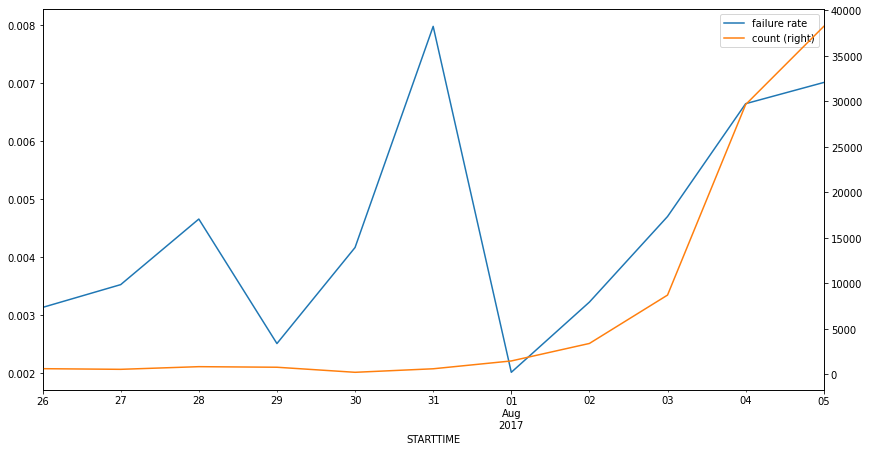

In [ ]:
data.groupby(pd.Grouper(key='STARTTIME', freq='D'))['Failure'].agg(['mean','count']).rename(columns={'mean':'failure rate'}).plot(secondary_y=['count'])

In [ ]:
data.groupby('STARTDATE')['Failure'].agg(['mean','count','sum'])

,mean,count,sum
STARTDATE,,,
2017-07-26,0.003135,638,2
2017-07-27,0.003527,567,2
2017-07-28,0.004657,859,4
2017-07-29,0.002513,796,2
2017-07-30,0.004167,240,1
2017-07-31,0.007974,627,5
2017-08-01,0.002017,1487,3
2017-08-02,0.003227,3409,11
2017-08-03,0.004700,8723,41


# Initial Model with all data

In [ ]:

x_cat_ls=['MACHINEID','MACHINEID_TESTER','LINE_ID','MODULE2_FACTORY','MODULE2_WoM','MODULE1_WoM',]
x_data=pd.get_dummies(data[x_cat_ls])
x_data['TESTDURATION']=data['TESTDURATION'].copy()
y_data=data['Failure']
print(len(x_data.columns))
#perform ordinary encoding to categorical features

# le.fit(tr_data[x_cate])
#subsample the data
X_train, X_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,test_size = 0.3, random_state = 22)
clfXG = XGBClassifier(nthread=-1,max_depth=6,learning_rate=0.05,n_setimator=100)
clfXG.fit(X_train,y_train)
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clfXG.feature_importances_}).sort_values('importance', ascending = False)

fi.head(50)

300


,feature,importance
296,MODULE2_FACTORY_MODULE2_FACTORY_7,0.094803
111,MACHINEID_TESTER_MACHINEID_TESTER_125,0.041774
146,MACHINEID_TESTER_MACHINEID_TESTER_157,0.037690
61,MACHINEID_MACHINEID_63,0.034367
298,MODULE2_FACTORY_MODULE2_FACTORY_9,0.033953
54,MACHINEID_MACHINEID_57,0.028239
0,MODULE2_WoM,0.022514
51,MACHINEID_MACHINEID_54,0.021062
295,MODULE2_FACTORY_MODULE2_FACTORY_6,0.020914
179,MACHINEID_TESTER_MACHINEID_TESTER_31,0.020208


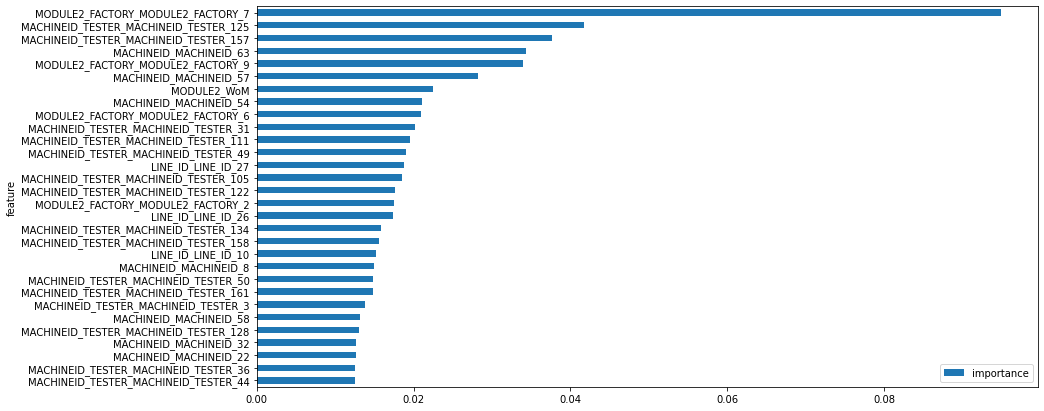

In [ ]:
fi.head(30).set_index("feature").sort_values('importance',ascending=True).plot(kind="barh")

In [ ]:
# calculate confusion matrix
y_train_pred = clfXG.predict(X_train)
y_test_pred = clfXG.predict(X_test)
print("train confusion matrix",'\n',confusion_matrix(y_train,y_train_pred),'\n')
print('train ROCAUC Score: ',roc_auc_score(y_train,clfXG.predict_proba(X_train)[:,1]),'\n')
print("train confusion matrix",'\n',confusion_matrix(y_test,y_test_pred),'\n')
print('test ROCAUC Score: ',roc_auc_score(y_test,clfXG.predict_proba(X_test)[:,1]),'\n')

train confusion matrix 
 [[59271     0]
 [  382    14]] 

train ROCAUC Score:  0.8643710050173581 

train confusion matrix 
 [[25431     1]
 [  139     1]] 

test ROCAUC Score:  0.7595356524962926 



# **MODULE2_FACTORY_7 Deep Dive **


In [ ]:
# check failure rate by factories 
fac_grp=data.groupby('MODULE2_FACTORY')['Failure'].agg(['sum','mean','count']).sort_values('count',ascending=False)
fac_grp['mean']=fac_grp['mean']*100
fac_grp.columns = ['total_failure_units','percent_of_failure','total_unit_count']
fac_grp

,total_failure_units,percent_of_failure,total_unit_count
MODULE2_FACTORY,,,
MODULE2_FACTORY_6,118,0.374247,31530
MODULE2_FACTORY_9,154,0.631769,24376
MODULE2_FACTORY_1,23,0.329136,6988
MODULE2_FACTORY_5,19,0.277210,6854
MODULE2_FACTORY_3,23,0.413001,5569
MODULE2_FACTORY_2,31,0.636943,4867
MODULE2_FACTORY_7,168,3.476102,4833
MODULE2_FACTORY_10,0,0.000000,104
MODULE2_FACTORY_4,0,0.000000,93


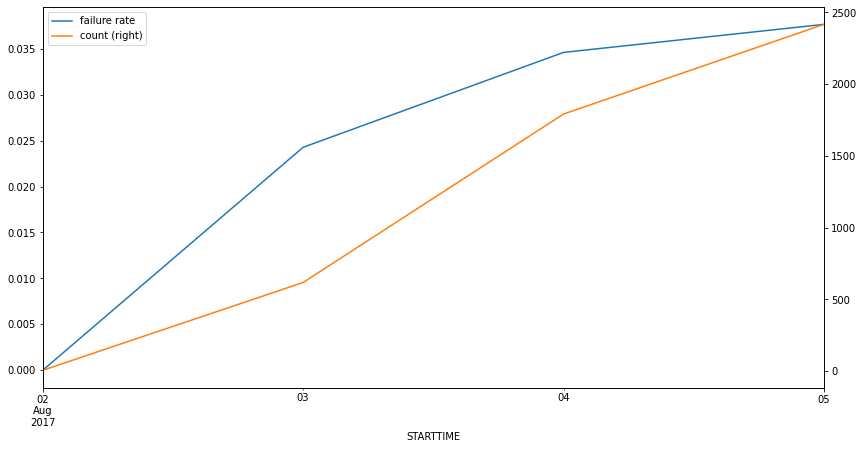

In [ ]:
#check factory 7 failure rate over time
msk=data['MODULE2_FACTORY']=='MODULE2_FACTORY_7'
data.loc[msk,].groupby(pd.Grouper(key='STARTTIME', freq='D'))['Failure'].agg(['mean','count']).rename(columns={'mean':'failure rate'}).plot(secondary_y=['count'])



In [ ]:
x_data=pd.DataFrame()
x_data['TESTDURATION']=data['TESTDURATION'].copy()
for var in ['MACHINEID','MACHINEID_TESTER','LINE_ID','MODULE2_FACTORY','MODULE2_WoM','MODULE1_WoM',]:
            x_data[var] = data[var].factorize()[0]

x_data.head()


In [ ]:
# to check is there any factors driving high failure rate in factory 7
msk=data['MODULE2_FACTORY']=='MODULE2_FACTORY_7'
fac_data=pd.get_dummies(data.loc[msk,['MACHINEID','MACHINEID_TESTER','LINE_ID','STARTDATE']])
fac_data[['TESTDURATION','MODULE2_WoM','MODULE1_WoM']] = data.loc[msk,['TESTDURATION','MODULE2_WoM','MODULE1_WoM']]
fac_data_y = data.loc[msk,'Failure']
clfXG = XGBClassifier(nthread=-1,max_depth=6,learning_rate=0.05,n_setimator=50)
clfXG.fit(fac_data,fac_data_y)
fi = pd.DataFrame({'feature': list(fac_data.columns),
                   'importance': clfXG.feature_importances_}).sort_values('importance', ascending = False)

fi.head(10)

,feature,importance
36,MODULE2_WoM,0.087780
34,STARTDATE_2017-08-05,0.051746
11,MACHINEID_TESTER_MACHINEID_TESTER_36,0.051434
3,MACHINEID_MACHINEID_22,0.050458
29,LINE_ID_LINE_ID_8,0.044084
32,STARTDATE_2017-08-03,0.042689
20,MACHINEID_TESTER_MACHINEID_TESTER_65,0.040732
15,MACHINEID_TESTER_MACHINEID_TESTER_54,0.040174
4,MACHINEID_MACHINEID_29,0.036537
6,MACHINEID_MACHINEID_32,0.035319


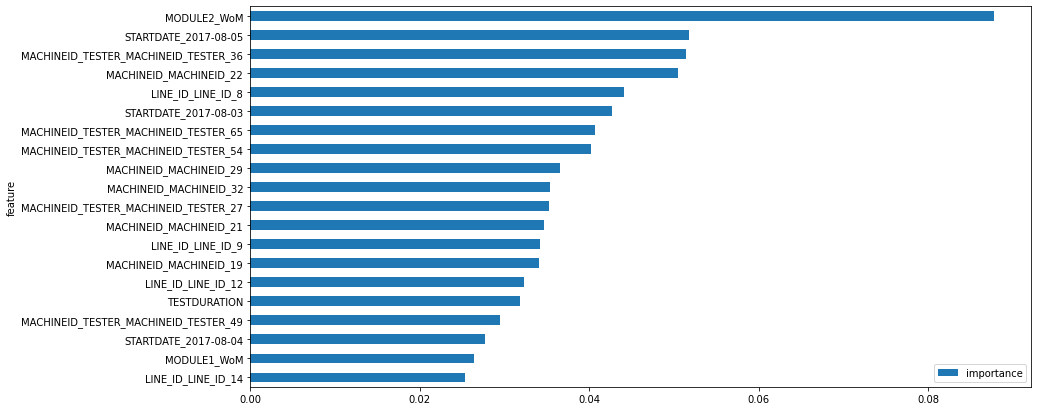

In [ ]:
fi.head(20).set_index("feature").sort_values('importance',ascending=True).plot(kind="barh")

In [ ]:
fac_grp_1=data.loc[msk,].groupby('MODULE2_WoM')['Failure'].agg(['sum','mean','count']).sort_values('count',ascending=False).head(20)
fac_grp_1['mean']=fac_grp_1['mean']*100
fac_grp_1.columns = ['total_failure_units','percent_of_failure','total_unit_count']
fac_grp_1

,total_failure_units,percent_of_failure,total_unit_count
MODULE2_WoM,,,
7196.0,7,1.351351,518
7197.0,7,1.394422,502
7201.0,6,1.442308,416
7231.0,0,0.000000,375
7202.0,6,1.948052,308
7227.0,0,0.000000,247
7195.0,11,5.164319,213
7232.0,1,0.478469,209
7194.0,12,6.217617,193


In [ ]:
# overall check machineId_TESTER exlcuding factory 7 
data.loc[~msk].groupby('MACHINEID_TESTER')['Failure'].agg(['sum','mean','count']).sort_values('sum',ascending=False).head(20)

,sum,mean,count
MACHINEID_TESTER,,,
MACHINEID_TESTER_125,55,0.021384,2572
MACHINEID_TESTER_113,24,0.008424,2849
MACHINEID_TESTER_128,19,0.006695,2838
MACHINEID_TESTER_134,16,0.007316,2187
MACHINEID_TESTER_117,14,0.005652,2477
MACHINEID_TESTER_146,13,0.005999,2167
MACHINEID_TESTER_122,12,0.004747,2528
MACHINEID_TESTER_155,9,0.010727,839
MACHINEID_TESTER_111,9,0.011719,768


In [ ]:
# overall check machine id exlcuding factory 7 
data.loc[~msk].groupby('MACHINEID')['Failure'].agg(['sum','mean','count']).sort_values('sum',ascending=False).head(20)

,sum,mean,count
MACHINEID,,,
MACHINEID_63,63,0.012691,4964
MACHINEID_54,43,0.007561,5687
MACHINEID_68,29,0.006661,4354
MACHINEID_58,26,0.005195,5005
MACHINEID_52,17,0.010828,1570
MACHINEID_57,15,0.003298,4548
MACHINEID_69,14,0.008289,1689
MACHINEID_55,12,0.003017,3978
MACHINEID_71,10,0.006614,1512


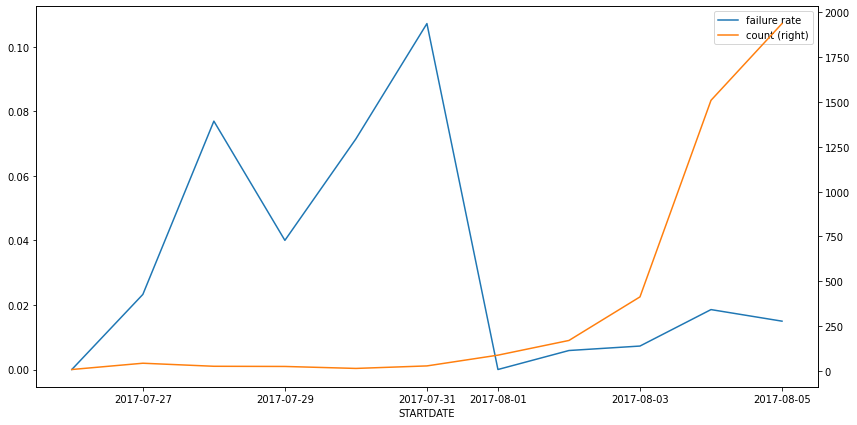

In [ ]:
# deep dive in machine id and machineid_tester
new_msk=(data['MACHINEID']=='MACHINEID_69') | (data['MACHINEID_TESTER']=='MACHINEID_TESTER_125')
data.loc[new_msk].groupby(['STARTDATE'])['Failure'].agg(['mean','count']).rename(columns={'mean':'failure rate'}).plot(secondary_y=['count'])



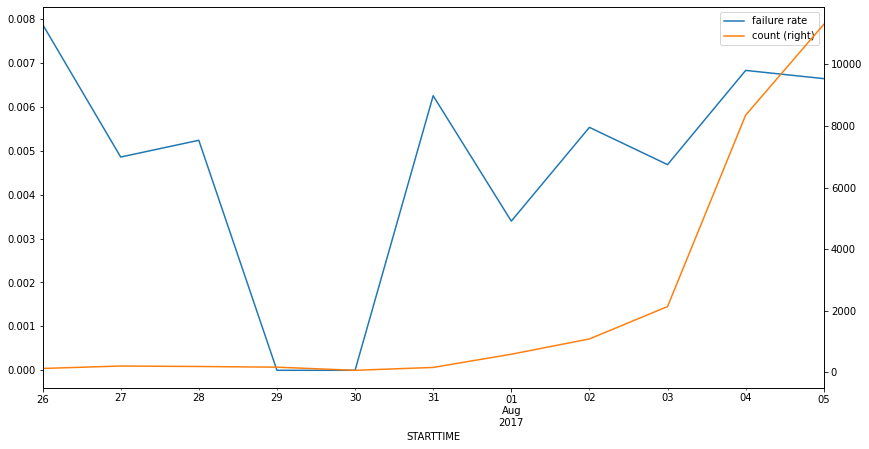

In [ ]:
#Deep diver into Factory 9
msk_2=data['MODULE2_FACTORY']=='MODULE2_FACTORY_9'
data.loc[msk_2,].groupby(pd.Grouper(key='STARTTIME', freq='D'))['Failure'].agg(['mean','count']).rename(columns={'mean':'failure rate'}).plot(secondary_y=['count'])



In [ ]:
fac_data_2=pd.get_dummies(data.loc[msk_2,['MACHINEID','MACHINEID_TESTER','LINE_ID','STARTDATE']])
fac_data_2[['TESTDURATION','MODULE2_WoM','MODULE1_WoM']] = data.loc[msk_2,['TESTDURATION','MODULE2_WoM','MODULE1_WoM']]
fac_data_y_2 = data.loc[msk_2,'Failure']
clfXG = XGBClassifier(nthread=-1,max_depth=6,learning_rate=0.05,n_setimator=50)
clfXG.fit(fac_data_2,fac_data_y_2)
fi = pd.DataFrame({'feature': list(fac_data_2.columns),
                   'importance': clfXG.feature_importances_}).sort_values('importance', ascending = False)

fi.head(10)

,feature,importance
52,MODULE2_WoM,0.061219
23,MACHINEID_TESTER_MACHINEID_TESTER_161,0.057044
35,LINE_ID_LINE_ID_31,0.048798
5,MACHINEID_MACHINEID_68,0.043789
20,MACHINEID_TESTER_MACHINEID_TESTER_146,0.043463
33,LINE_ID_LINE_ID_29,0.041077
7,MACHINEID_MACHINEID_71,0.040490
22,MACHINEID_TESTER_MACHINEID_TESTER_157,0.039789
2,MACHINEID_MACHINEID_57,0.037410
30,LINE_ID_LINE_ID_26,0.035389


In [ ]:
data.loc[msk_2].groupby(['MODULE2_WoM'])['Failure'].agg(['mean','count','sum']).sort_values('sum',ascending=False)

,mean,count,sum
MODULE2_WoM,,,
7196.0,0.093750,128,12
7214.0,0.002945,2377,7
7213.0,0.002879,2431,7
7212.0,0.004508,1331,6
7205.0,0.021505,279,6
...,...,...,...
7163.0,0.000000,228,0
7162.0,0.000000,162,0
7161.0,0.000000,111,0
